## Always run this

In [1]:
import sys
import os

file_path = os.getcwd()
parent_dir = os.path.split(file_path)[0]
sys.path.insert(0, parent_dir + "/pyblip/")
sys.path.insert(0, parent_dir + "/knockpy/")
sys.path.insert(0, parent_dir + "/blip_sims/")
import pyblip
import knockpy
import blip_sims

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *

import knockpy

In [3]:
def calc_mean_sem(data, group_vals, meas, trunc_zero=True):
    """
    Groups data by group_vals and then calculates mean, standard error
    for each column.
    """
    agg_df = data.groupby(group_vals)[meas].agg(['mean', 'sem']).reset_index()
    for m in meas:
        agg_df[f'{m}_mean'] = agg_df[m]['mean']
        agg_df[f'{m}_se'] = agg_df[m]['sem']
        agg_df[f'{m}_ymin'] =  agg_df[f'{m}_mean'] - 2*agg_df[f'{m}_se']
        if trunc_zero:
            agg_df[f'{m}_ymin'] = np.maximum(0, agg_df[f'{m}_ymin'])
        agg_df[f'{m}_ymax'] =  agg_df[f'{m}_mean'] + 2*agg_df[f'{m}_se']
    
    agg_df = agg_df.loc[:, agg_df.columns.get_level_values(1) == '']
    agg_df.columns = agg_df.columns.get_level_values(0)
    return agg_df

In [4]:
import plotnine as gg
import matplotlib.pyplot as plt
import matplotlib.image as img

def _check_plotnine_grid(plots_list, figsize):
    if not type(plots_list) == list:
        raise ValueError('Input plots_list is not a list')
    if (not type(figsize) == tuple) or (not len(figsize) == 2):
        raise ValueError('Input figsize should be a tuple of length 2')

def plotnine_grid(plots_list, row=None, col=1, height=None, width=None, dpi=500, ratio=None, pixels=10000,
                  figsize=(12, 8)):

    """
    Create a grid of plotnine plots.


    Function input
    ----------
    plots_list      : a list of plotnine.ggplots
    row, col        : numerics to indicate in how many rows and columns the plots should be ordered in the grid
                  defaults: row -> length of plots_list; col -> 1
    height, width   : the height and width of the individual subplots created by plotnine
                    can be automatically determined by a combination of dpi, ratio and pixels
    dpi             : the density of pixels in the image. Default: 500. Higher numbers could lead to crisper output,
                    depending on exact situation
    ratio           : the ratio of heigth to width in the output. Standard value is 1.5 x col/row.
                    Not used if height & width are given.
    pixels          : the total number of pixels used, default 10000. Not used if height & width are given.
    figsize         : tuple containing the size of the final output after making a grid, in pixels (default: (1200,800))



    Function output
    ----------
    A matplotlib figure that can be directly saved with output.savefig().
    """

    _check_plotnine_grid(plots_list, figsize)  # Check the input

    # Assign values that have not been provided based on others. In the end, height and width should be provided.
    if row is None:
        row = len(plots_list)

    if ratio is None:
        ratio = 1.5 * col / row

    if height is None and width is not None:
        height = ratio * width

    if height is not None and width is None:
        width = height / ratio

    if height is None and width is None:
        area = pixels / dpi
        width = np.sqrt(area/ratio)
        height = ratio * width

    # Do actual subplot creation and plot output.
    i = 1
    fig = plt.figure(figsize=figsize)
    plt.autoscale(tight=True)
    for image_sel in plots_list:  # image_sel = plots_list[i]
        image_sel.save('image' + str(i) + '.png', height=height, width=width, dpi=500, verbose=False)
        fig.add_subplot(row, col, i)
        plt.imshow(img.imread('image' + str(i) + '.png'), aspect='auto')
        fig.tight_layout()
        fig.get_axes()[i-1].axis('off')
        i = i + 1
        os.unlink('image' + str(i - 1) + '.png')  # os.unlink is basically os.remove but in some cases quicker
    fig.patch.set_visible(False)
    return fig

## 1.2 Example plots

### 1.2.1 Changepoint example

In [5]:
# Generate data
np.random.seed(123) # original good one
T = 100
delta = 0.75 # original: 1.75
X = np.arange(T)
Y = np.random.randn(T)
Y[int(T/2):] += delta
mu = np.zeros(T)
mu[int(T/2):] += delta

In [6]:
# # Plot #1
# df = pd.DataFrame()
# df['X'] = X
# df['Y'] = Y
# fig, ax = plt.subplots(figsize=(3,2))
# ax = sns.regplot(
#     ax=ax,
#     data=df, 
#     x='X', 
#     y='Y', 
#     color='#6495ED',
#     label='Y',
#     line_kws={'color':'seagreen'},
# )
# #ax = lmplot.axes[0, 0]
# ax.plot(X[0:int(T/2)], mu[0:int(T/2)],
#     color='red',
#     label='True mean',
#     linestyle='dashed'
# )
# ax.plot(X[int(T/2):], mu[int(T/2):],
#     color='red',
#     linestyle='dashed'
# )
# ax.set(xlabel='t', ylabel='Y')
# ax.legend()
# #plt.savefig("final-plots/changepoint_example.png", dpi=500)

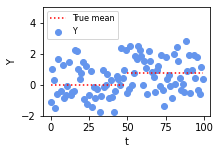

In [35]:
# Plot #2
fig, ax = plt.subplots(figsize=(3,2))
ax.scatter(X, Y, label='Y', color='#6495ED')
ax.plot(X[0:int(T/2)], mu[0:int(T/2)],
    color='red',
    label='True mean',
    linestyle='dotted'
)
ax.plot(X[int(T/2):], mu[int(T/2):],
    color='red',
    linestyle='dotted'
)
ax.set(ylabel='Y', xlabel='t')
ax.set_ylim(-2, 5)
ax.legend(loc=(2), prop={'size': 8})
#plt.show()
plt.savefig("final-plots/changepoint_example.png", dpi=500)

### 1.2.2 Astro Example

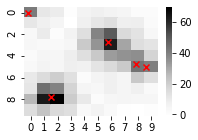

In [258]:
import scipy.signal 

# Create x, y
p = 10
z = np.zeros((p, p))
x = np.arange(p).reshape(-1, 1)
x = np.repeat(x, p, axis=1)
y = x.T

# Create point sources
np.random.seed(110)
# k = 15
# xsource = 10*np.random.uniform(size=(k,))
# ysource = 10*np.random.uniform(size=(k,))
# magsource = 20 + np.abs(10*np.random.randn(k))


xsource = [0.5, 8.25, 5.234, 5.5398, 3.234097]
ysource = [0.25, 2, 8.357098, 9.12309, 6.2509]
magsource = [50, 100, 35, 25, 83]

# Create means 
mu = z.copy()
for (i, j, mag) in zip(xsource, ysource, magsource):
    d = np.sqrt(np.power(i-x-0.5, 2) + np.power(j-y-0.5,2))
    mu += mag * np.exp(-1*d)


# Create data
D = np.sqrt(mu) * np.random.randn(p, p) + mu #3*np.random.randn(p, p) + mu

# Plot
fig, ax = plt.subplots(figsize=(3,2))
ax = sns.heatmap(D, cmap='Greys', ax=ax)
ax.scatter(ysource, xsource, color='red', marker='x', label='True Sources')
#ax.legend(bbox_to_anchor=(1.1, 1.3))
plt.savefig("final-plots/astro_example.png", dpi=500)

### 1.2.3 Noncentral F-test

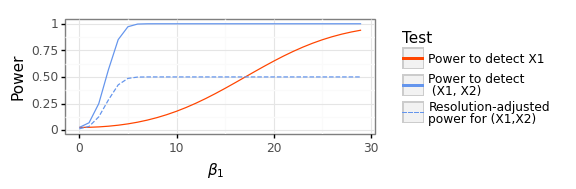

/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 4 x 1.5 in image.
/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: final-plots/examples/ftest_example.png


In [387]:
import numpy as np
import pandas as pd
from scipy import stats
from plotnine import *

# Columns for data-matrix
columns = [
    'beta1', 
    'Power to detect X1',
    'Power to detect \n (X1, X2)',
    'Resolution-adjusted\npower for (X1,X2)']
output = []

# Parameters
n = 20
alpha = 0.05
rho = 0.99

# Thresholds with bonferonni correction
t1 = stats.f(dfn=1, dfd=n-2).ppf(1-alpha/2)
t2 = stats.f(dfn=2, dfd=n-2).ppf(1-alpha/2)

# Power of tests for various beta
betas = np.arange(30)
mu1 = (1 - rho**2) * np.power(betas, 2)
mu2 = np.power(betas, 2)
power1 = 1 - stats.ncf(nc=mu1, dfn=1, dfd=n-2).cdf(t1)
power2 = (1 - stats.ncf(nc=mu2, dfn=2, dfd=n-2).cdf(t2))
res_adj_power2 = power2 / 2

# Put into dataframe and plot
df = pd.DataFrame(columns=columns)
df['beta1'] = betas
df[columns[1]] = power1
df[columns[2]] = power2
df[columns[3]] = res_adj_power2
df = pd.melt(df, id_vars=['beta1'], value_name='Power', var_name='Test')
df['Test'] = pd.Categorical(
    df['Test'], 
    ordered=True, 
    categories=columns[1:4]
)
g = (
    ggplot(
        df, 
        aes(x='beta1', y='Power', color='Test')
    )
    + geom_line(aes(linetype='Test'))
    #+ geom_point()
    + theme_bw()
    + theme(figure_size=(4,1.5))
    + labs(
        x=r'$\beta_1$',
        y='Power'
    )
    + scale_linetype_manual(['solid', 'solid', 'dashed'])
    + scale_color_manual(['orangered', 'cornflowerblue', 'cornflowerblue'])
)
print(g)
g.save("final-plots/examples/ftest_example.png", dpi=500)

In [20]:
def H_mat(X):
    inv = np.linalg.inv(np.dot(X.T, X))
    return np.dot(X, np.dot(inv, X.T))

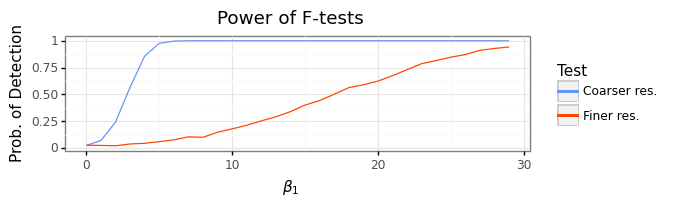

In [22]:
#### For testing, we also simulate the power curves.
#### This plot is not published since it's just
#### a sanity check :)

n = 20
cov = np.array([[1, rho], [rho, 1]])
L = np.linalg.cholesky(cov)

# Generate X s.t. XTX = cov
X = np.dot(L, np.random.randn(2, n-2)).T / np.sqrt(5*(n-2))
cov_left = cov - np.dot(X.T, X)
L_left = np.linalg.cholesky(cov_left)
X = np.concatenate([X, L_left.T], axis=0)

# Invert
XTXinv = np.linalg.inv(np.dot(X.T, X))

# For f-tests
H = H_mat(X)
H2 = H_mat(X[:, [1]])

# Generate y | X
for beta1 in betas:
    for j in range(1000):
        y = X[:, 0] * beta1 + np.random.randn(n)

        # F-test testing beta1, beta2 = 0
        denom = np.dot(y, np.dot(np.eye(n) - H, y)) / (n - 2)
        T1 = np.dot(y, np.dot(H - H2, y)) / denom
        T2 = np.dot(y, np.dot(H, y)) / 2 / denom

        # append
        output.append([beta1, T1 > t1, T2 > t2])

cols= ['beta1', 'Finer res.', 'Coarser res.']
df = pd.DataFrame(output, columns=cols)
df = pd.melt(df, id_vars=['beta1'], value_name='Power', var_name='Test')
agg = calc_mean_sem(
    df, 
    group_vals=['beta1', 'Test'], 
    meas=['Power']
)
g = (
    ggplot(
        agg, 
        aes(x='beta1', y='Power_mean', color='Test')
    )
    + geom_line()
    + theme_bw()
    + theme(figure_size=(6,1.5))
    + labs(
        title='Power of F-tests', 
        x=r'$\beta_1$',
        y='Prob. of Detection'
    )
    + scale_color_manual(['cornflowerblue', 'orangered'])
)
print(g)

In [29]:
np.dot(np.dot(X.T, (H - H2)), X)

array([[ 1.99000000e-02, -3.40003147e-15],
       [-3.30089338e-15, -3.40320307e-15]])

In [34]:
H1 = H_mat(X[:, [0]])
np.dot(np.dot(X.T, H1), X)

array([[1.    , 0.99  ],
       [0.99  , 0.9801]])

## 2.3 Integer-relaxation plots

In [92]:
import numpy as np
import pandas as pd
from plotnine import *

day = '2021-12-14'
t = '20-11-34' 

data = pd.read_csv(f"data/lp_int_sol/{day}/{t}/results.csv")

In [93]:
id_vars = ['kappa', 'p', 'sparsity', 'covmethod']
#cov_dict = {'ar1':'AR1', 'ver':'ErdosRenyi (Cov.)', 'qer':'ErdosRenyi (Prec.)'}
cov_dict = {'ar1':'AR1', 'ver':'VER', 'qer':'QER'}

### Averages of number of randomized pairs/singletons

In [94]:
var_dict = {
    'n_singleton':'Other non-integers', 'n_rand_pairs':'Randomized pairs'
}
mdata = pd.melt(
    data[id_vars + ['n_rand_pairs', 'n_singleton']],
    id_vars=id_vars,
    var_name='variable',
    value_name='value'
)
mdata['variable'] = mdata['variable'].map(var_dict)
agg_df = calc_mean_sem(mdata, group_vals=id_vars + ['variable'], meas=['value'])
agg_df['covmethod'] = agg_df['covmethod'].map(cov_dict)
agg_df.head()

,kappa,p,sparsity,covmethod,variable,value_mean,value_se,value_ymin,value_ymax
,,,,,,,,,
0,0.025,1000,0.05,AR1,Other non-integers,0.500000,0.052026,0.395948,0.604052
1,0.025,1000,0.05,AR1,Randomized pairs,0.195312,0.082304,0.030705,0.359920
2,0.025,1000,0.05,QER,Other non-integers,0.304688,0.042322,0.220043,0.389332
3,0.025,1000,0.05,QER,Randomized pairs,0.085938,0.042998,0.000000,0.171934
4,0.025,1000,0.05,VER,Other non-integers,0.250000,0.038424,0.173153,0.326847


g = (
    ggplot(
        agg_df, aes(x='kappa', y='value_mean', color='variable')
    )
    + geom_point(alpha=0.5)
    + geom_line(alpha=0.5)
    + geom_errorbar(aes(ymin="value_ymin", ymax="value_ymax"), width=0.01)
    + facet_wrap("~covmethod")
    + labs(x=r'n / p', y='Average Count', color='Variable')
    + theme(
        figure_size=(6,1),
        axis_text_x=element_text(angle=0)
    )
    + scale_color_manual(['red', 'blue'])

)
g.save("final-plots/section2/randomization_counts.png", dpi=500)
print(g)

### Averages of objective function

In [95]:
#data['epower_ilp_diff'] = (data['epower_ilp']  - data['epower_lp']) 
#data['epower_sample_diff'] =  (data['epower_sample'] - data['epower_lp'])
meas_dict= {
    'epower_lp':'Upper bound\n(relaxed LP)',
    'epower_ilp':'BLiP (deterministic)',
    'epower_sample':'BLiP (randomized)'
}
# meas_dict = {
#     #'epower_lp':'Relaxed LP',
#     'epower_ilp_diff':'BLiP (deterministic)',
#     'epower_sample_diff':'BLiP (randomized)'
# }
meas = list(meas_dict.keys())
# melt
mdata = pd.melt(
    data[id_vars + meas],
    id_vars=id_vars,
    var_name='measurement',
    value_name='value'
)

agg_df = calc_mean_sem(
    mdata,
    group_vals=id_vars + ['measurement'], 
    meas=['value'],
    trunc_zero=False
)
agg_df['measurement'] = agg_df['measurement'].map(meas_dict)
agg_df['covmethod'] = agg_df['covmethod'].map(cov_dict)

/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6 x 1.5 in image.
/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: final-plots/section2/objective_gap.png


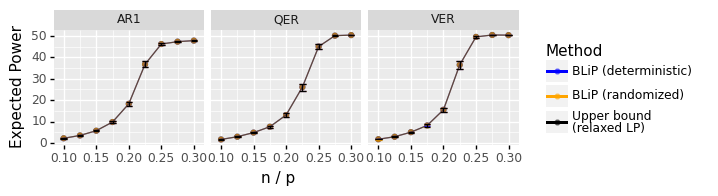

In [96]:
sub = agg_df.loc[(agg_df['kappa'] >= 0.1)]
g = (
    ggplot(
        sub, aes(x='kappa', y='value_mean', color='measurement')
    )
    + geom_point(alpha=0.5)
    + geom_line(alpha=0.5)
    + geom_errorbar(aes(ymin="value_ymin", ymax="value_ymax"), width=0.01)
    + facet_wrap("~covmethod")
    + labs(x=r'n / p', y='Expected Power', color='Method')
    + theme(
        figure_size=(6,1.5),
        axis_text_x=element_text(angle=0)
    )
    + scale_color_manual(['blue', 'orange', 'black'])
)
g.save("final-plots/section2/objective_gap.png", dpi=500)
print(g)

# Section 3

## High-dimensional case (p=1000). When done, delete other high-dim cases below

To-do: no need to run DAP, just have a separate table which compares the powers in a few settings and also shows computation time. We can defer this to an appendix.

In [20]:
days = [
    '2022-01-06', '2022-01-06', '2022-01-09', 
    '2022-01-09', '2022-01-09', '2022-01-09',
    '2022-01-10', '2022-01-10'
]
ts = [
    '12-51-08', '12-51-50', '12-56-51', 
    '12-56-52', '12-56-55', '18-00-44',
    '13-01-04', '13-01-31'
]

data_list = []
for day, t in zip(days, ts):
    data_list.append(pd.read_csv(f"data/glms/{day}/{t}/results.csv"))
data = pd.concat(data_list, axis='index')
data['power'] = 100 * data['power'] / (data['p'] * data['sparsity'])

# Change method names
data['method'] = data['method'].str.replace('dap-g', 'DAP-G')
data['method'] = data['method'].str.replace('susie', 'SuSiE')

# Drop nfd, not needed and complicates melting
data = data.drop("nfd", axis='columns')
# Melt for FDR/Power in 1 graph
data = data.melt(
    id_vars=[c for c in data.columns if c not in ['power', 'fdr']],
    var_name='Measurement'
)

data['total_time'] = data['model_time'] + data['blip_time']

agg = calc_mean_sem(
    data,
    group_vals=[
        'method', 'y_dist', 'covmethod', 'kappa', 'p',
        'Measurement', 'sparsity', 'k', 'well_specified'],
    meas=['model_time', 'value', 'blip_time', 'total_time']
)
agg['y_dist'] = agg['y_dist'].astype(str)
agg['kappa'] = np.around(agg['kappa'], 2)

def row2method(row):
    if 'LSS' in row['method'] or 'PSS' in row['method']:
        if not row['well_specified']:
            return row['method'] + '\n(misspec.)'
    return row['method']

agg['Method'] = agg.apply(row2method, axis='columns')

In [21]:
colors = [
    'gray', # dap
    'lightgreen', # FBH
    'blue', # LSS + BLiP 
    'cornflowerblue', # LSS + BLiP (misspec)
    'purple', # PSS + BLiP 
    'lavender', # PSS + BLiP (misspec)
    'orangered', #"susie"
    'crimson', #"susie + BLiP",
    'darkgreen', # Yekutieli
]
methods = sorted(agg['Method'].unique())
method2color = {method:color for method, color in zip(methods, colors)}

/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6 x 2.5 in image.
/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: final-plots/section3/linear_sparsity_hdim.png


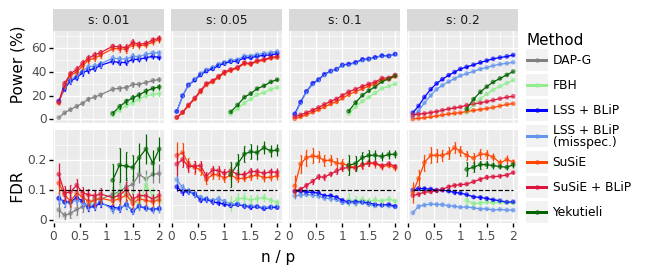

In [25]:
agg['s'] = "s: " + agg['sparsity'].astype(str)
agg['meas'] = agg['Measurement'].map({'fdr':"  ", "power":" "})

for y_dist in ['gaussian']:
    if y_dist == 'gaussian':
        reg_type = "Linear"
    else:
        reg_type = 'Logistic'
    for meas in ['value']:
        g =  (
            ggplot(
                agg.loc[(agg['y_dist'] == y_dist)],# & (agg['method'] == 'dap-g')],
                aes(
                    x='kappa', y=f'{meas}_mean', ymin=f'{meas}_ymin', ymax=f'{meas}_ymax',
                    color='Method'
                )
            ) 
            + geom_line()
            + geom_point(size=1, alpha=0.5)
            + geom_errorbar(width=0.01)
            + facet_grid("meas~s", scales='free', labeller='label_value')
            + labs(
                x='n / p',
                y=f'     FDR              Power (%)',
                #title=f'{reg_type} Regression on AR(5) design'
            )
            + theme(
                strip_text_y=element_blank(),
                figure_size=(6,2.5),
                legend_position=(1.0, 0.5),
            )
            + scale_color_manual(method2color)
        )
        qline = agg.loc[
            (agg['method'] == 'SuSiE') &
            (agg['y_dist'] == y_dist) &
            (agg['Measurement'] == 'fdr')
        ].copy()
        qline[f'{meas}_mean'] = 0.1
        g += geom_line(
            data=qline,
            mapping=aes(
                x='kappa',
                y=f'{meas}_mean'
            ),
            inherit_aes=False,
            color='black',
            linetype='dashed'
            )
        g.save("final-plots/section3/linear_sparsity_hdim.png", dpi=500)
        print(g)


In [14]:
agg.loc[
    (agg['kappa'] == 2) &
    (agg['method'] == 'FBH') &
    (agg['y_dist'] == 'gaussian'),
    ['total_time_mean', 's']
]

,total_time_mean,s
88,883.938191,s: 0.01
89,918.517765,s: 0.05
90,908.291138,s: 0.1
91,916.958992,s: 0.2
92,883.938191,s: 0.01
93,918.517765,s: 0.05
94,908.291138,s: 0.1
95,916.958992,s: 0.2


In [40]:
meas = 'model_time'
g = (ggplot(
    agg.loc[(agg['y_dist'] == 'gaussian')],# & (agg['method'] == 'dap-g')],
    aes(
        x='kappa', y=f'{meas}_mean', ymin=f'{meas}_ymin', ymax=f'{meas}_ymax',
        color='Method'
    )
) 
+ geom_line()
+ geom_point(alpha=0.5)
+ geom_errorbar(width=0.01)
+ facet_wrap("~s", scales='free', labeller='label_value')
+ labs(
    x='n / p',
    y=f'Time',
    title=f'{reg_type} Regression on AR(5) design'
)
+ theme(
    strip_text_y=element_blank(),
    figure_size=(6,3),
)
+ scale_color_manual(method2color))
print(g)

KeyError: 'y_dist'

### Probit setting

In [14]:
days = [
    '2022-01-11', '2022-01-11', '2022-01-11'
]
ts = [
    '23-57-22', '23-58-59', '23-59-39'
]

data_list = []
for day, t in zip(days, ts):
    data_list.append(pd.read_csv(f"data/glms/{day}/{t}/results.csv"))
data = pd.concat(data_list, axis='index')
data['power'] = 100 * data['power'] / (data['p'] * data['sparsity'])

# Change method names
data['method'] = data['method'].str.replace('dap-g', 'DAP-G')
data['method'] = data['method'].str.replace('susie', 'SuSiE')

# Drop nfd, not needed and complicates melting
data = data.drop("nfd", axis='columns')
# Melt for FDR/Power in 1 graph
data = data.melt(
    id_vars=[c for c in data.columns if c not in ['power', 'fdr']],
    var_name='Measurement'
)

data['total_time'] = data['model_time'] + data['blip_time']

agg = calc_mean_sem(
    data,
    group_vals=[
        'method', 'y_dist', 'covmethod', 'kappa', 'p',  'coeff_size',
        'Measurement', 'sparsity', 'k', 'well_specified'],
    meas=['model_time', 'value', 'blip_time', 'total_time']
)
agg['y_dist'] = agg['y_dist'].astype(str)
agg['kappa'] = np.around(agg['kappa'], 2)

def row2method(row):
    if 'LSS' in row['method'] or 'PSS' in row['method']:
        if not row['well_specified']:
            return row['method'] + '\n(misspec.)'
    return row['method']

agg['Method'] = agg.apply(row2method, axis='columns')

/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6 x 2.5 in image.
/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: final-plots/section3/probit_power_fdr.png


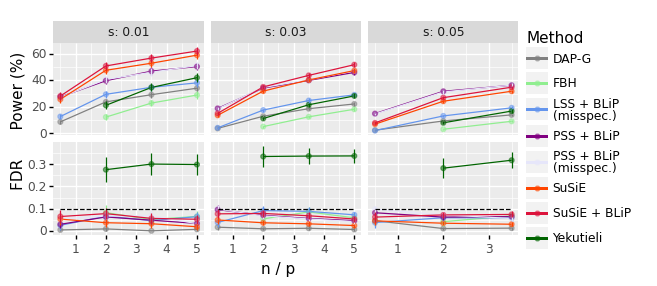

In [19]:
colors = [
    'gray', # dap
    'lightgreen', # FBH
    #'blue', # LSS + BLiP 
    'cornflowerblue', # LSS + BLiP (misspec)
    'purple', # PSS + BLiP 
    'lavender', # PSS + BLiP (misspec)
    'orangered', #"susie"
    'crimson', #"susie + BLiP",
    'darkgreen', # Yekutieli
]
methods = sorted(agg['Method'].unique())
method2color = {method:color for method, color in zip(methods, colors)}

agg['s'] = agg['sparsity'].astype(str)
#agg['s'] = "s: " + agg['sparsity'].astype(str)
agg['meas'] = agg['Measurement'].map({'fdr':"  ", "power":" "})

meas = 'value'
g =  (
    ggplot(
        agg,# & (agg['method'] == 'dap-g')],
        aes(
            x='kappa', y=f'{meas}_mean', ymin=f'{meas}_ymin', ymax=f'{meas}_ymax',
            color='Method'
        )
    ) 
    + geom_line()
    + geom_point(alpha=0.5)
    + geom_errorbar(width=0.001)
    + facet_grid("meas~s", scales='free', labeller='label_both')
    + labs(
        x=r'n / p',
        y=f'       FDR      Power (%)',
        #title=f'Probit Regression on AR(5) design'
    )
    + theme(
        strip_text_y=element_blank(),
        figure_size=(6,2.5),
        legend_position=(1.0,0.5),
        
    )
    + scale_color_manual(method2color)
)
qline = agg.loc[
    (agg['method'] == 'SuSiE') &
    (agg['Measurement'] == 'fdr')
].copy()
qline[f'{meas}_mean'] = 0.1
g += geom_line(
    data=qline,
    mapping=aes(
        x='kappa',
        y=f'{meas}_mean'
    ),
    inherit_aes=False,
    color='black',
    linetype='dashed'
    )
g.save("final-plots/section3/probit_power_fdr.png", dpi=500)
print(g)


## Power for low-dimensional case (p = 400)

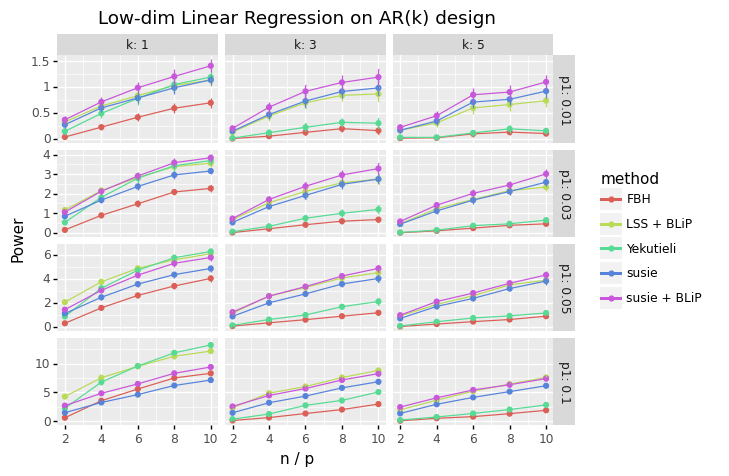

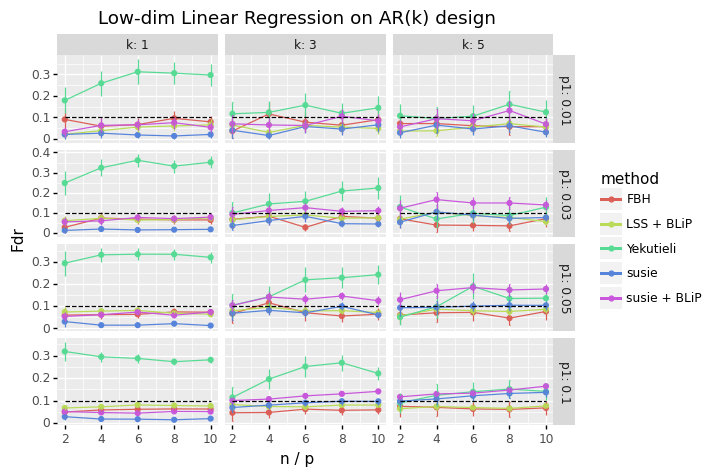

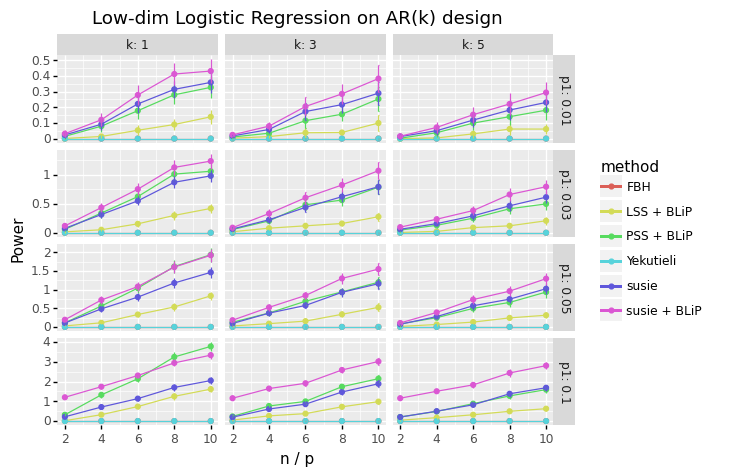

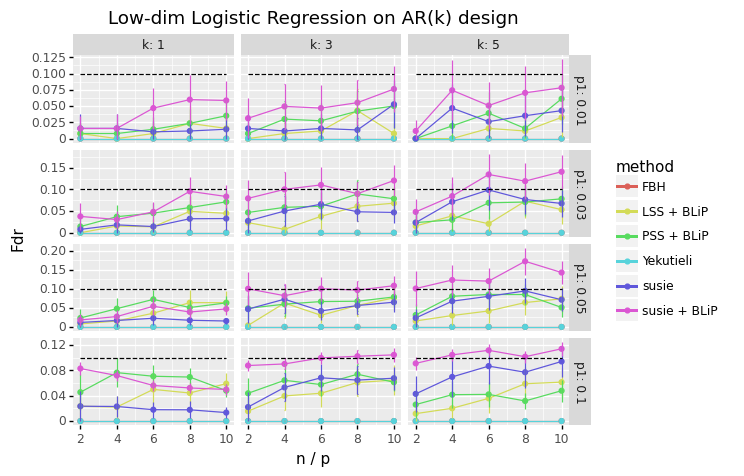

In [16]:
day = '2021-12-21'
t = '00-09-00' 
#t = '00-13-45'

data = pd.read_csv(f"data/glms/{day}/{t}/results.csv")

agg = calc_mean_sem(
    data,
    group_vals=['method', 'y_dist', 'covmethod', 'kappa', 'p', 'sparsity', 'k'],
    meas=['model_time', 'power', 'fdr', 'blip_time']
)
agg['p1'] = agg['sparsity'].astype(str)
agg['y_dist'] = agg['y_dist'].astype(str)
agg['kappa'] = np.around(agg['kappa'], 2)

for y_dist in ['gaussian', 'binomial']:
    if y_dist == 'gaussian':
        reg_type = "Linear"
    else:
        reg_type = 'Logistic'
    for meas in ['power', 'fdr']:
        g =  (
            ggplot(
                agg.loc[agg['y_dist'] == y_dist],
                aes(
                    x='kappa', y=f'{meas}_mean', ymin=f'{meas}_ymin', ymax=f'{meas}_ymax',
                    color='method'
                )
            ) 
            + geom_line()
            + geom_point()
            + geom_errorbar(width=0.01)
            + facet_grid("p1~k", scales='free', labeller='label_both')
            + labs(
                x='n / p',
                y=f'{meas.capitalize()}',
                title=f'Low-dim {reg_type} Regression on AR(k) design'
            )
        )
        if meas == 'fdr':
            qline = agg.loc[agg['method'] == 'susie'].copy()
            qline[f'{meas}_mean'] = 0.1
            g += geom_line(
                data=qline,
                mapping=aes(
                    x='kappa',
                    y=f'{meas}_mean'
                ),
                inherit_aes=False,
                color='black',
                linetype='dashed'
            )
        print(g)


### Computation as n, p grow

Add another line (x10) and see how much power gain we have.

#### Attempt 2 (better)

In [37]:
day = '2022-01-06'
t = '13-00-20' 

data = pd.read_csv(f"data/glms/{day}/{t}/results.csv")
data['power'] = 100 * data['power'] / (data['sparsity'] * data['p']) 
data['method'] = data['method'].str.replace('susie', 'SuSiE')

def row2method1(row):
    if 'LSS' in row['method'] or 'PSS' in row['method']:
        return row['method'] + f"\n(niter={5*row['nsample']})"
    return row['method']

group_vals=['method', 'y_dist', 'covmethod', 'kappa', 'p', 'sparsity', 'k', 'nsample']

agg = calc_mean_sem(
    data,
    group_vals=group_vals,
    meas=['model_time', 'power', 'fdr', 'blip_time']
)
agg['kappa'] = np.around(agg['kappa'], 2)
agg['Method'] = agg.apply(row2method1, axis='columns')

In [394]:
data2 = data[group_vals + ['model_time', 'blip_time']]
data2 = pd.melt(
    data2,
    id_vars=group_vals,
    var_name='Type',
    value_name='Time'
)
data2 = data2.loc[data2['Time'] != 0]
agg2 = calc_mean_sem(
    data2,
    group_vals=group_vals + ['Type'],
    meas=[ 'Time'],
    trunc_zero=False
)

def row2method(row):
#     if row['Type'] == 'blip_time':
#         if 'LSS' in row['method']:
#             return f'BLiP (LSS {row["nsample"]})'
#         else:
#             return 'BLiP (SuSiE)'
#     else:
    if 'LSS' in row['method']:
        return f'LSS {row["nsample"]}'
    elif 'dap' in row['method']:
        return 'DAP'
    else:
        return 'SuSiE'
    
agg2['Method'] = agg2.apply(row2method, axis='columns')

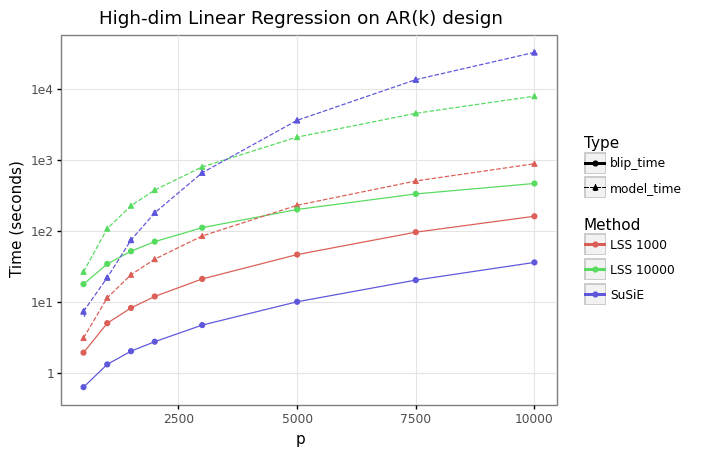

In [395]:
meas = 'Time'
g =  (
    ggplot(
        agg2,
        aes(
            x='p', y=f'{meas}_mean', ymin=f'{meas}_ymin', ymax=f'{meas}_ymax',
            color='Method'
        )
    ) 
    + geom_line(aes(linetype='Type'))
    + geom_point(aes(shape='Type'))
    + geom_errorbar(width=0.01)
    #+ facet_wrap("~p", scales='free' if meas=='Time' else 'fixed')
    + labs(
        x='p',
        y=f'{meas.capitalize()} (seconds)',
        title=f'High-dim Linear Regression on AR(k) design'
    )
)
g += scale_y_log10()
g += theme_bw()
g += theme(
    panel_grid_minor = element_blank(), 
)
print(g)


### Option 2

In [398]:
data3 = data.copy()
data3['total_time'] = data3['model_time'] + data3['blip_time']
data3 = data3[group_vals + ['model_time', 'total_time', 'blip_time']]
data3 = pd.melt(
    data3,
    id_vars=group_vals + ['blip_time'],
    var_name='Type',
    value_name='Time'
)
data3 = data3.loc[
    (data3['blip_time'] != 0) | (data3['Type'] == 'model_time')
]    
agg3 = calc_mean_sem(
    data3,
    group_vals=group_vals + ['Type'],
    meas=['Time'],
    trunc_zero=False
)

def row2method(row):
    if 'LSS' in row['method']:
        return f'LSS\n(niter={5*row["nsample"]})'
    elif 'dap' in row['method']:
        return 'DAP'
    else:
        return 'SuSiE'
    
agg3['Method'] = agg3.apply(row2method, axis='columns')
agg3['Type'] = agg3['Type'].map(
    {'model_time':'Model only', 'total_time':'Total\n(Model+BLiP)'}
)

/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 3 x 2 in image.
/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: final-plots/section3/linear_vp_time.png


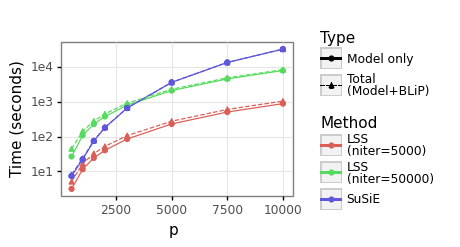

<ggplot: (8779053961406)>

In [399]:
meas = 'Time'
g =  (
    ggplot(
        agg3,
        aes(
            x='p', y=f'{meas}_mean', ymin=f'{meas}_ymin', ymax=f'{meas}_ymax',
            color='Method'
        )
    ) 
    + geom_line(aes(linetype='Type'))
    + geom_point(aes(shape='Type'))
    + geom_errorbar(width=0.01)
    + labs(
        x='p',
        y=f'{meas.capitalize()} (seconds)',
    )
    + scale_y_log10()
    + theme_bw()
    + theme(
        panel_grid_minor = element_blank(), 
        figure_size=(3,2)
    )
)
g.save("final-plots/section3/linear_vp_time.png", dpi=500)
g

/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 3 x 2 in image.
/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: final-plots/section3/linear_vp_power.png


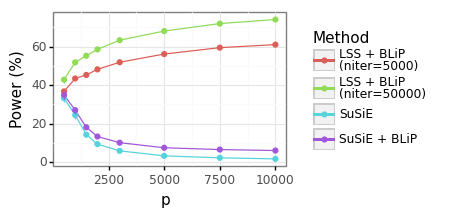

/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 3 x 2 in image.
/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: final-plots/section3/linear_vp_fdr.png


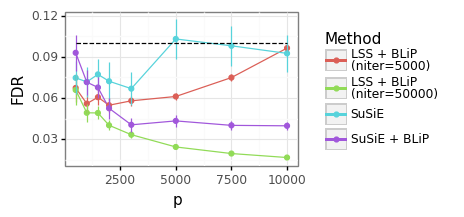

In [393]:
for meas in ['power', 'fdr']:
    g =  (
        ggplot(
            agg,
            aes(
                x='p', y=f'{meas}_mean', ymin=f'{meas}_ymin', ymax=f'{meas}_ymax',
                color='Method'
            )
        ) 
        + geom_line()
        + geom_point()
        + geom_errorbar(width=0.01)
        + labs(
            x='p',
            y=f'Power (%)' if meas == 'power' else 'FDR',
        )
        + theme_bw()
        + theme(figure_size=(3,2), strip_margin=0)
    )
    if meas == 'fdr':
        qline = agg.loc[agg['method'] == 'SuSiE'].copy()
        qline[f'{meas}_mean'] = 0.1
        g += geom_line(
            data=qline,
            mapping=aes(
                x='p',
                y=f'{meas}_mean'
            ),
            inherit_aes=False,
            color='black',
            linetype='dashed'
        )
    g.save(f"final-plots/section3/linear_vp_{meas}.png", dpi=500)
    print(g)



## 4. Changepoint simulations and plots

### 4a Susie convergence example

The Susie CS are: [{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99}]


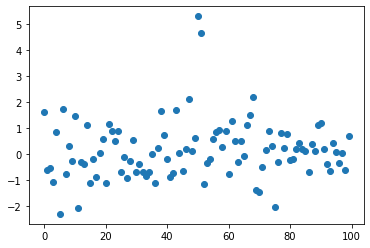

In [566]:
# Replicated from susie hard convergence example
np.random.seed(1)
T = 100
toy_x = np.random.randn(T)
toy_x[50:52] += 5
plt.scatter(np.arange(T), toy_x)
susie_alphas, susie_cs = blip_sims.susie.run_susie_trendfilter(
    toy_x, order=0, L=10, q=0.1
)
print("The Susie CS are:", [set(x) for x in susie_cs])

In [567]:
X = np.ones((T, T-1))
for j in range(T-1):
    X[0:(j+1), j] = 0

In [568]:
lm = pyblip.linear.LinearSpikeSlab(X=X, y=toy_x)
lm.sample(N=10000, chains=5)
inclusions = lm.betas != 0
cand_groups = pyblip.create_groups.sequential_groups(inclusions)
toy_blip_output = pyblip.blip.BLiP(cand_groups=cand_groups, q=0.1)

BLiP problem has 374 groups in contention, with 51 active features/locations


### Harder toy example

In [569]:
np.random.seed(111)
coeff_size = 2
sparsity = 0.04
T = 200
X, Y, beta = blip_sims.gen_data.gen_changepoint_data(
    T=T, coeff_size=coeff_size, sparsity=sparsity, coeff_dist='uniform'
)

In [570]:
lm = pyblip.linear.LinearSpikeSlab(
    X=X, y=Y, p0=1-sparsity, update_p0=False, sigma2=1, update_sigma2=False, tau2=coeff_size, update_tau2=False
)
lm.sample(N=20000, chains=5, burn=100)
inclusions = lm.betas != 0
inclusions[:, 0] = 0
cand_groups = pyblip.create_groups.sequential_groups(inclusions, max_size=20)
blip_output = pyblip.blip.BLiP(cand_groups=cand_groups, q=0.05)
# fig = plot_changepoint_results(
#     Y, beta, 
#     [x.group for x in blip_output],
# )
# plt.savefig("final-plots/section3/cp_hard_toy_ex.png")
# plt.show()

BLiP problem has 1276 groups in contention, with 171 active features/locations


### Plotting

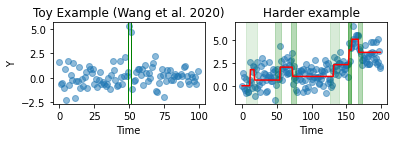

In [574]:
fig, axes = plt.subplots(1, 2, figsize=(6,1.5))
# Susie toy example
axes[0].scatter(np.arange(len(toy_x)), toy_x, alpha=0.5)
for j, signal in enumerate(toy_blip_output):
    cs = signal.group
    axes[0].axvspan(
        min(cs), max(cs), 
        alpha=1,
        color='green'
    )
    
# This will plotnothing since since susie makes no real discoveries
for cs in susie_cs:
    if len(cs) <= 25:
        ax.axvspan(min(cs), max(cs), alpha=0.5, color='orange', label='Susie')
        
# Harder example
axes[1].scatter(np.arange(len(Y)), Y, alpha=0.5)
axes[1].plot(np.arange(len(beta)), np.cumsum(beta), color='red')
detections = [x.group for x in blip_output]
nnulls = set(np.where(beta != 0)[0].tolist())
minlen = min([len(cs) for cs in detections]) / 2
for j, cs in enumerate(detections):
    if len(nnulls.intersection(cs)) > 0:
        color = 'green'
    else:
        color = 'orange'
    axes[1].axvspan(min(cs), max(cs), alpha=minlen / len(cs), color=color, label='BLiP' if j == 0 else None)
    
axes[0].set(title="Toy Example (Wang et al. 2020)")
axes[1].set(title="Harder example")
for j in [0,1]:
    axes[j].set(xlabel='Time')
axes[0].set(ylabel='Y')

plt.savefig("final-plots/section3/cp_exes.png", dpi=500, bbox_inches='tight')

### 4b Slightly less sparsity / signal

In [471]:
# def plot_changepoint_results(Y, beta, detections, susie_detections=None, title=None):
#     fig, ax = plt.subplots(figsize=(3,2))
#     plt.scatter(np.arange(T), Y, color='blue')
#     plt.plot(np.arange(T), np.cumsum(beta), color='red')
#     nnulls = set(np.where(beta != 0)[0].tolist())
#     minlen = min([len(cs) for cs in detections])
#     for j, cs in enumerate(detections):
#         if len(nnulls.intersection(cs)) > 0:
#             color = 'green'
#         else:
#             color = 'orange'
#         ax.axvspan(min(cs), max(cs), alpha=minlen / len(cs), color=color, label='BLiP' if j == 0 else None)
#     if susie_detections is not None:
#         for j,cs in enumerate(susie_detections):
#             if len(nnulls.intersection(cs)) > 0:
#                 color = 'blue'
#             else:
#                 color = 'orange'
#         ax.axvspan(min(cs), max(cs), alpha=minlen / len(cs), color=color, label='BLiP' if j == 0 else None)
#     ax.set(title=title)
#     return fig


In [503]:
# np.random.seed(111)
# coeff_size = 2
# sparsity = 0.04
# T = 200
# X, Y, beta = blip_sims.gen_data.gen_changepoint_data(
#     T=T, coeff_size=coeff_size, sparsity=sparsity, coeff_dist='uniform'
# )

In [470]:
# T = Y.shape[0]
# plt.scatter(np.arange(T), Y)
# plt.plot(np.arange(T), np.cumsum(beta), color='red')

In [528]:
# lm = pyblip.linear.LinearSpikeSlab(
#     X=X, y=Y, p0=1-sparsity, update_p0=False, sigma2=1, update_sigma2=False, tau2=coeff_size, update_tau2=False
# )
# lm.sample(N=20000, chains=5, burn=100)
# inclusions = lm.betas != 0
# inclusions[:, 0] = 0
# cand_groups = pyblip.create_groups.sequential_groups(inclusions, max_size=20)
# blip_output = pyblip.blip.BLiP(cand_groups=cand_groups, q=0.05)
# # fig = plot_changepoint_results(
# #     Y, beta, 
# #     [x.group for x in blip_output],
# # )
# # plt.savefig("final-plots/section3/cp_hard_toy_ex.png")
# # plt.show()

In [527]:
# susie_alphas, susie_cs = blip_sims.susie.run_susie_trendfilter(Y, int(0), int(10), q=0.05)
# susie_cs = [x+1 for x in susie_cs] # Adjust index to be correct
# plot_changepoint_results(Y, beta, [set(x.tolist()) for x in susie_cs], title='Susie')

### Simulation results, T = 200

In [38]:
day = '2022-01-07'
t = '18-27-52' 
day2 = '2022-01-11'
t2 = '03-10-37'

# Read data
data1 = pd.read_csv(f"data/changepoint/{day}/{t}/results.csv")
data1 = data1.loc[data1['well_specified']]
data2 = pd.read_csv(f"data/changepoint/{day2}/{t2}/results.csv")
data2 = data2.loc[~data2['well_specified']]
data = pd.concat([data1, data2], axis='index')

data['s'] = data['sparsity']
data['power'] = 100*data['power'] / (data['p'] * data['s'])

# Change method names
data['method'] = data['method'].str.replace('susie', 'SuSiE')

# Drop nfd, not needed and complicates melting
data = data.drop("nfd", axis='columns')
# Melt for FDR/Power in 1 graph
data = data.melt(
    id_vars=[c for c in data.columns if c not in ['power', 'fdr']],
    var_name='Measurement'
)


group_vals=['well_specified', 'Method', 'p', 'sparsity', 'coeff_size', 'nsample']

def row2method(row):
    if row['well_specified']:
        return row['method']
    return row['method'] + '\n(misspec)'
data['Method'] = data.apply(row2method, axis='columns')
data['Method'] = data['Method'].str.replace('susie', 'SuSiE')

agg = calc_mean_sem(
    data,
    group_vals=group_vals + ['Measurement'],
    meas=['model_time', 'value', 'blip_time']
)
agg['s'] = "s: " + agg['sparsity'].astype(str)
agg['meas'] = agg['Measurement'].map({'fdr':"  ", "power":" "})

/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6 x 2 in image.
/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: final-plots/section3/cp_power_fdr.png


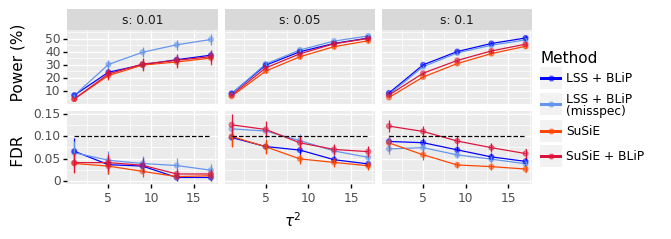

In [39]:
meas = 'value'
g =  (
    ggplot(
        agg,
        aes(
            x='coeff_size', y=f'{meas}_mean', ymin=f'{meas}_ymin', ymax=f'{meas}_ymax',
            color='Method'
        )
    ) 
    + geom_line()
    + geom_point(alpha=0.5)
    + geom_errorbar(width=0.01)
    + facet_grid("meas~s", scales='free', labeller='label_value')
    + labs(
        x=r'$\tau^2$',
        y=f'     FDR       Power (%)\n'
    )
    + theme(
        strip_text_y=element_blank(),
        figure_size=(6,2),
        legend_position=(1.0, 0.5),
    )
    + scale_color_manual(['blue', 'cornflowerblue', 'orangered', 'crimson'])
)
qline = agg.loc[
    (agg['Method'] == 'SuSiE') &
    (agg['Measurement'] == 'fdr')
].copy()
qline[f'{meas}_mean'] = 0.1
g += geom_line(
    data=qline,
    mapping=aes(
        x='coeff_size',
        y=f'{meas}_mean'
    ),
    inherit_aes=False,
    color='black',
    linetype='dashed'
    )
g.save("final-plots/section3/cp_power_fdr.png", dpi=500)
print(g)